# Importing necessary libraries

In [77]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_squared_log_error
%matplotlib inline

# Importing and loading the training dataset

In [78]:
data=pd.read_csv('boombikes.csv',encoding='latin-1')
df=pd.DataFrame(data)
df.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,6,0,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,0,0,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,1,1,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,2,1,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,3,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


# Exploring the training dataset

In [79]:
#Checking for missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Thus, this dataset contains no missing values

In [80]:
#Function to check for outliers
def chk_outliers(arr):
    Q1=np.quantile(arr,0.25)
    median=np.median(arr)
    Q3=np.quantile(arr,0.75)
    IQR=Q3-Q1
    upper_limit=Q3+(1.5*IQR)
    lower_limit=Q1-(1.5*IQR)
    outliers=arr[(arr<lower_limit)|(arr>upper_limit)]
    return len(outliers)

#Using this function to identify columns with outliers
outlier_cols=[]
for col in df.columns:
    if df[col].dtype!='object':
        conv=np.array(df[col])
        count=chk_outliers(conv)
        if count>0:
            outlier_cols.append(col)
    else:
        continue
L=len(outlier_cols)
if L>0:
    print(f"{L} columns have outliers, which are: {outlier_cols}".format())
else:
    print("This dataset contains no outliers.")

4 columns have outliers, which are: ['holiday', 'hum', 'windspeed', 'casual']


In [81]:
#Viewing the no. of outliers in each such column
outlier_dict={}
for idx in outlier_cols:
    col_arr=np.array(df[idx])
    outlier_dict[idx]=chk_outliers(col_arr)
outlier_df=pd.DataFrame(outlier_dict.items(),columns=['Column','Outlier_Count'])
outlier_df

,Column,Outlier_Count
0,holiday,21
1,hum,2
2,windspeed,13
3,casual,44


In [82]:
#Statistical information
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Data preprocessing and visualization

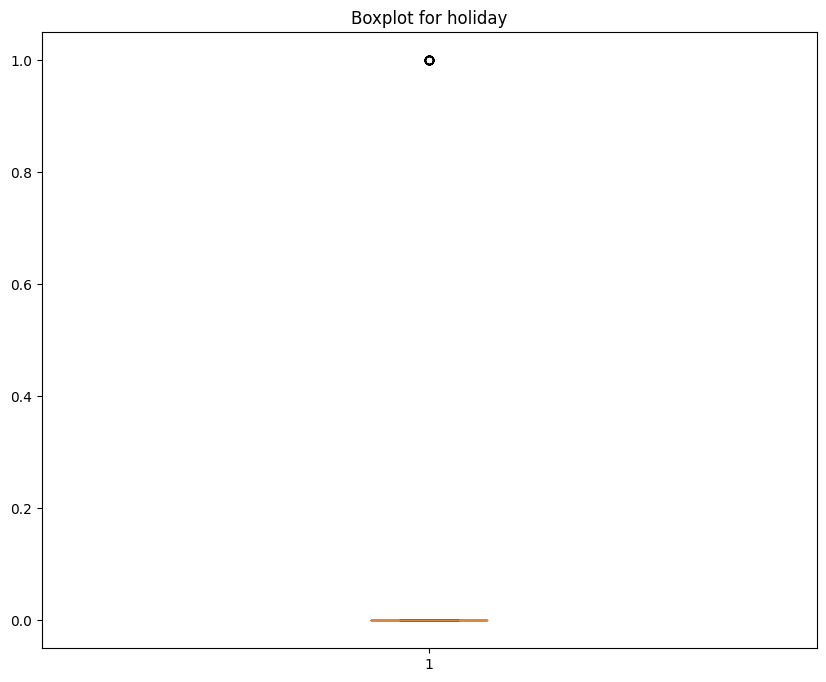

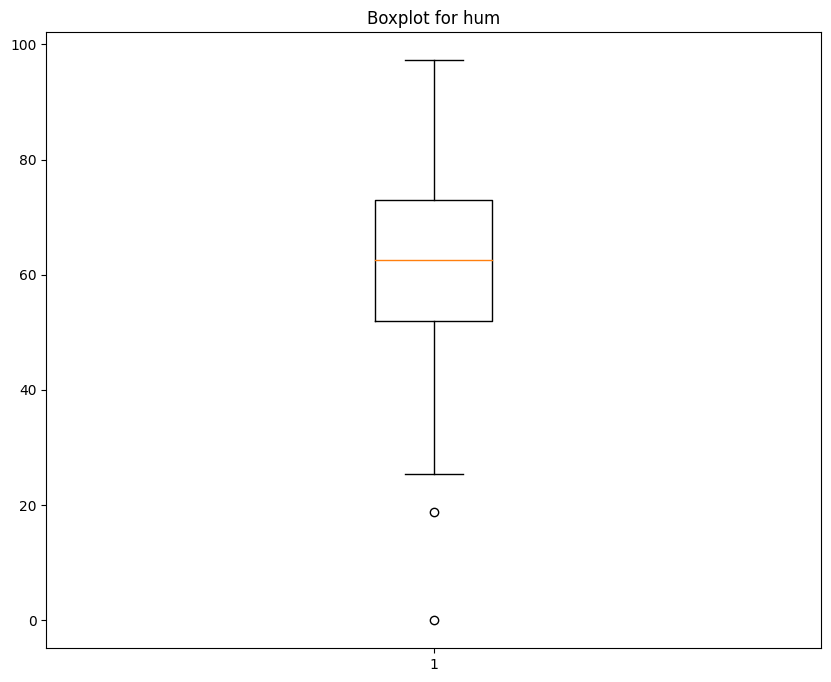

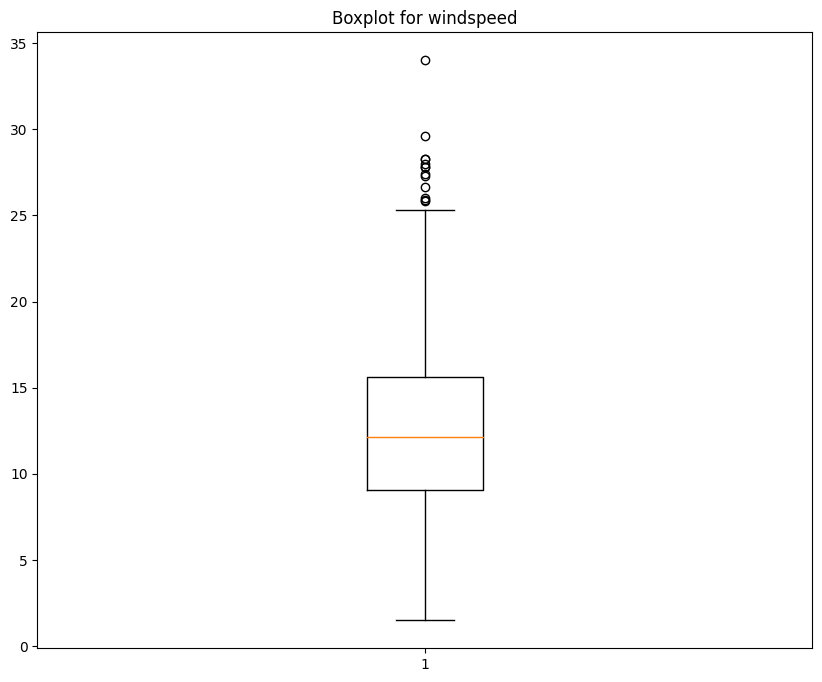

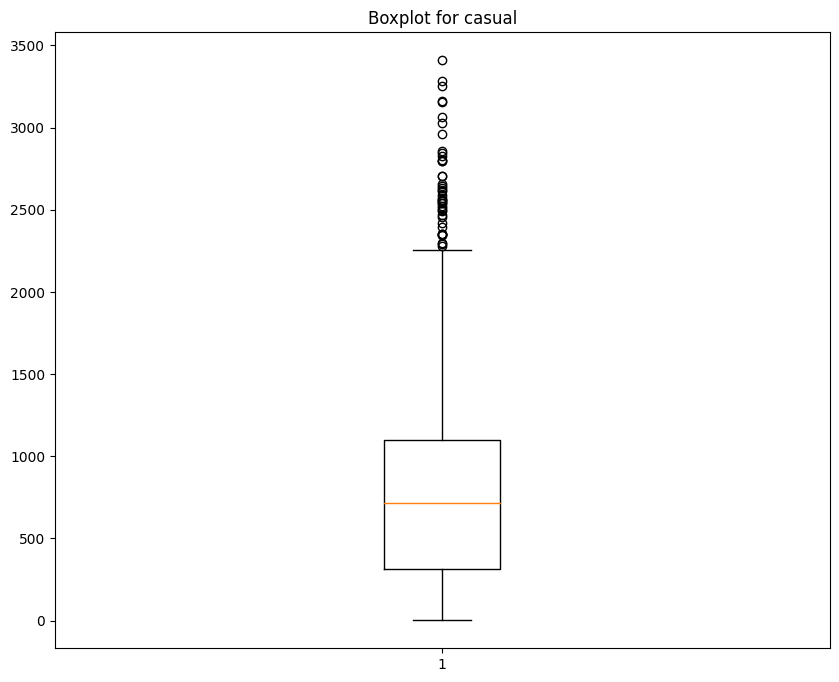

In [83]:
#Plotting initial boxplots
for attr in outlier_cols:
    plt.figure(figsize=(10,8))
    plt.boxplot(df[attr])
    plt.title(f"Boxplot for {attr}")
    plt.show()

In [84]:
#Encoding the non-numeric columns
object_cols=[]
for column in df.columns:
    if df[column].dtype=='object':
        object_cols.append(column)
enc=OrdinalEncoder()
df[object_cols]=enc.fit_transform(df[object_cols])

C:\Users\Adity\AppData\Local\Temp\ipykernel_63816\1425351874.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,1)


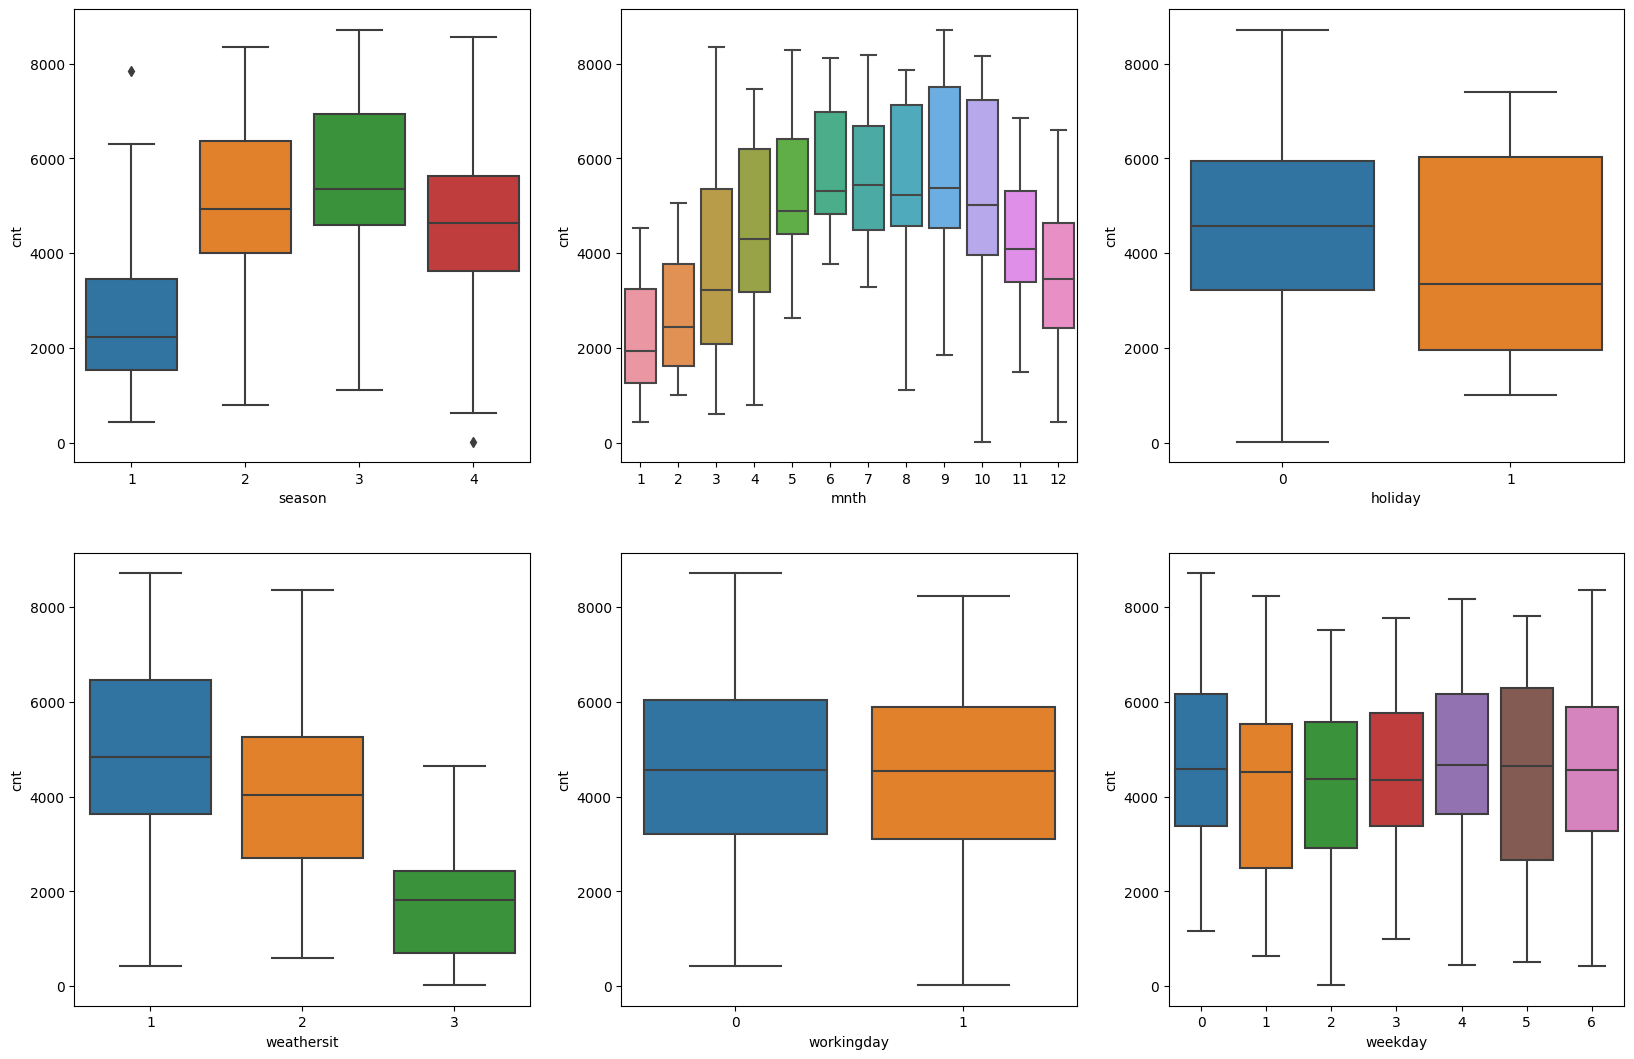

In [85]:
#Plotting boxplots for various parameters
plt.figure(figsize=(20,20))
plt.title('Boxplot for various parameters')
plt.subplot(3,3,1)
sns.boxplot(x='season',y='cnt',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='mnth',y='cnt',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='holiday',y='cnt',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='weathersit',y='cnt',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='workingday',y='cnt',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='weekday',y='cnt',data=df)
plt.show()

C:\Users\Adity\AppData\Local\Temp\ipykernel_63816\4110634076.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['temp'])
C:\Users\Adity\AppData\Local\Temp\ipykernel_63816\4110634076.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['atemp'])


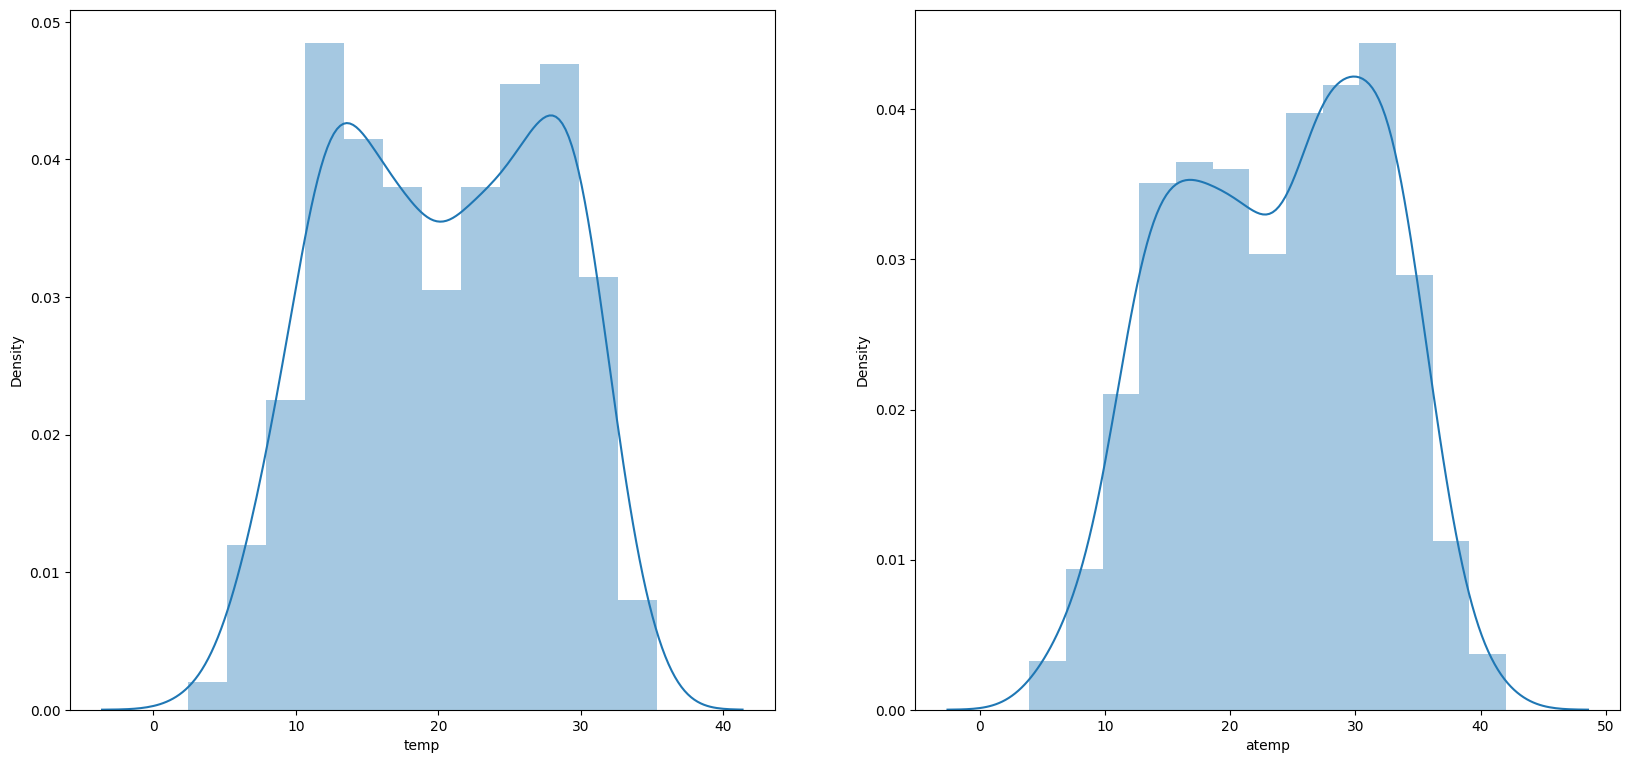

In [86]:
#Plotting distplots for various parameters
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.distplot(df['temp'])
plt.subplot(2,2,2)
sns.distplot(df['atemp'])
plt.show()

<Figure size 2000x2000 with 0 Axes>

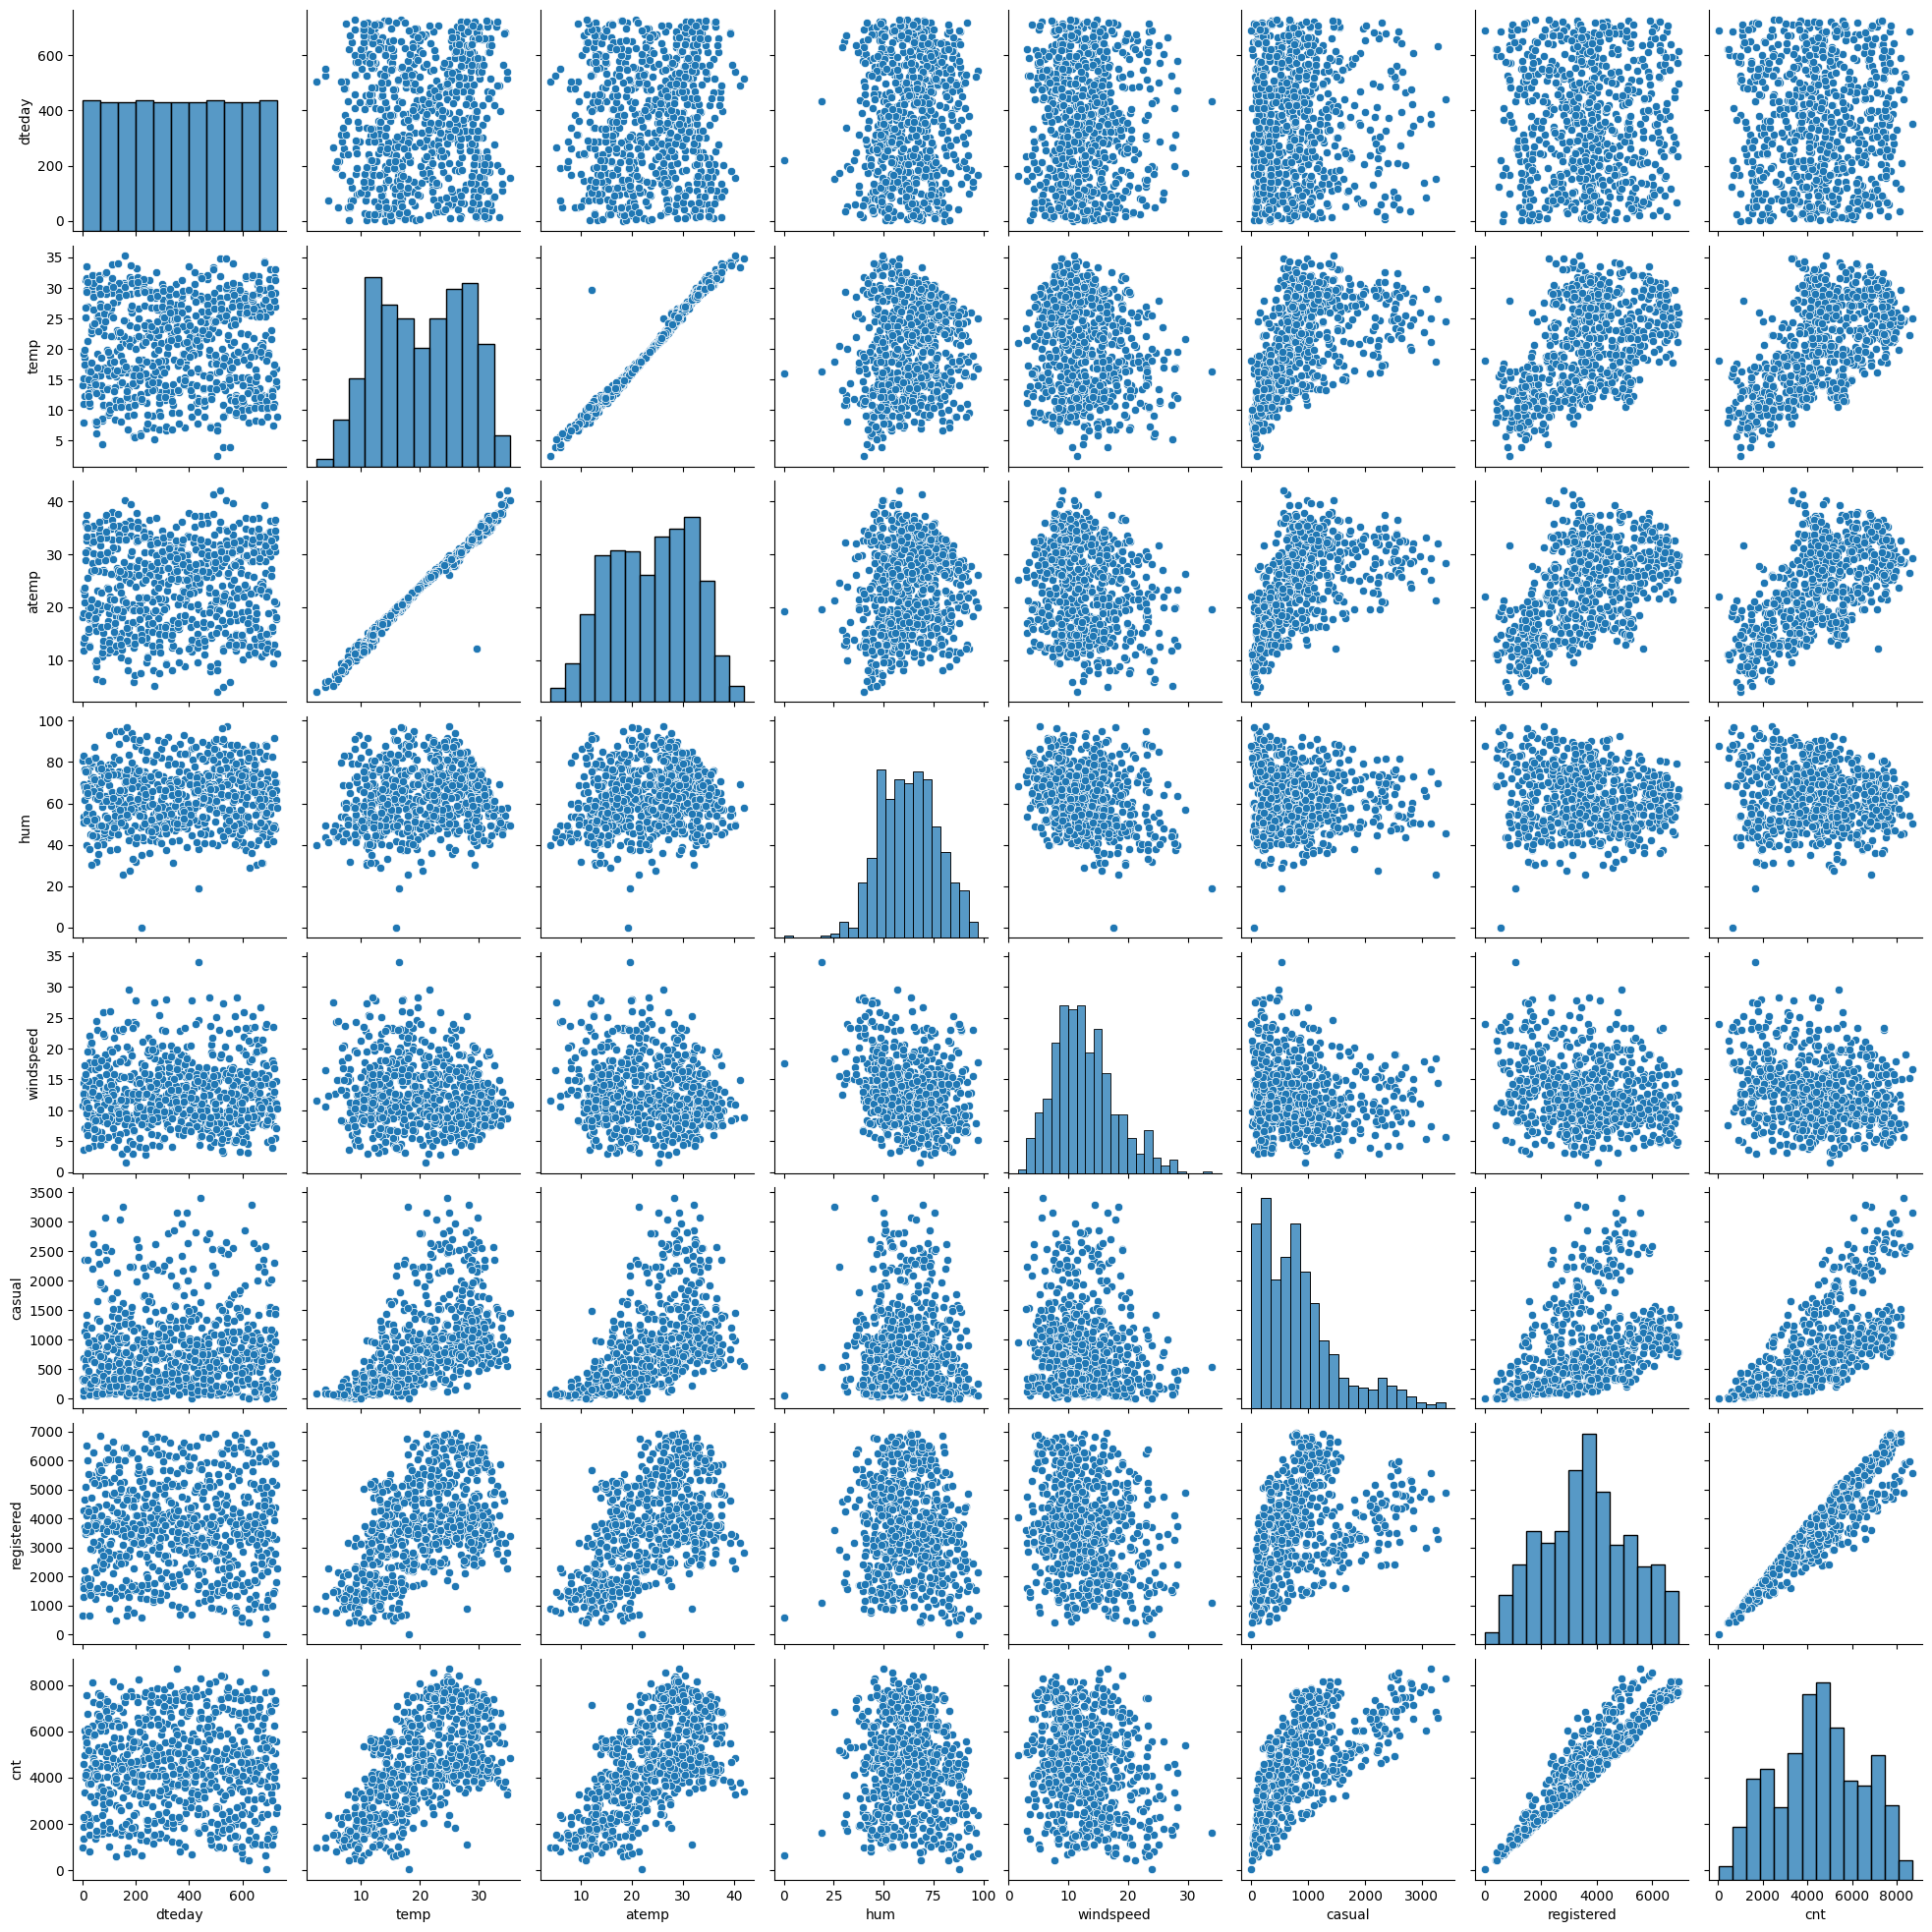

In [87]:
#Plotting the pairplot for the numeric values in the dataset
intVarList=['casual','registered','cnt']
for var in intVarList:
    df[var]=df[var].astype('float64')
df_numeric=df.select_dtypes(include=['float64'])
plt.figure(figsize=(20,20))
sns.pairplot(df_numeric)
plt.show()

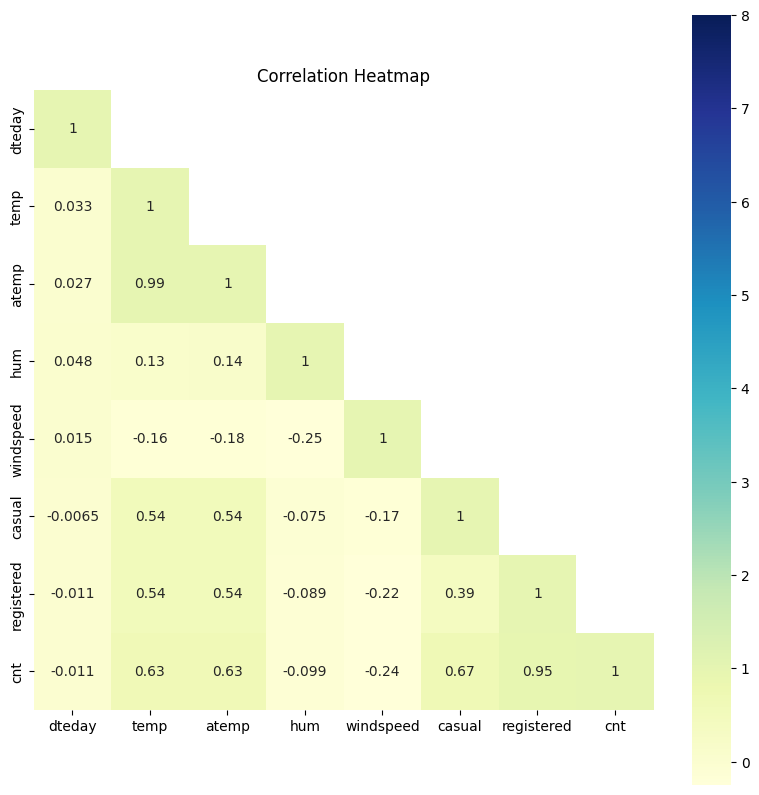

In [88]:
#Plotting the correlation heatmap
corr=df_numeric.corr()
mask=np.array(corr)
mask[np.tril_indices_from(mask)]=False
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corr,mask=mask,vmax=8,square=True,annot=True,cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

Here, the attribute 'atemp' can be removed, as it is highly correlated with the attribute 'temp'.

In [89]:
#Removing atemp
df.drop(['atemp'],axis=1,inplace=True)

In [90]:
#Scaling the non-categorical attributes
noc=['temp','hum','windspeed','casual','registered','cnt']
scaler=MinMaxScaler()
df[noc]=scaler.fit_transform(df[noc])

In [91]:
#Splitting the dataset into predictors and target
predictors=df.drop(['cnt'],axis=1)
target=df['cnt']

#Splitting the dataset into training and test datasets
pred_train,pred_test,tar_train,tar_test=train_test_split(predictors,target,test_size=0.3,random_state=42)

# Building, Training and evaluating the ML models

# 1. Gradient Boosting Regressor model

In [92]:
#Building and training the model
GBR=GradientBoostingRegressor(n_estimators=100,max_depth=7)
GBR.fit(pred_train,tar_train)

#Making predictions
GBR_predictions=GBR.predict(pred_test)

#Evaluating the model
GBR_RMSE=mean_squared_error(GBR_predictions,tar_test,squared=False)
print(f"RMSE for Gradient Bossting Regressor: {GBR_RMSE:.3f}".format())

RMSE for Gradient Bossting Regressor: 0.016


# 2. XGBoost Regressor

In [93]:
#Building and training the model
XGB=xgb.XGBRegressor(n_estimators=100,max_depth=7)
XGB.fit(pred_train,tar_train)

#Making predictions
XGB_predictions=XGB.predict(pred_test)

#Evaluating the model
XGB_RMSE=mean_squared_error(XGB_predictions,tar_test,squared=False)
print(f"RMSE for XGBoost Regressor: {XGB_RMSE:.3f}".format())

RMSE for XGBoost Regressor: 0.015


# 3. Bagging Regressor model

In [94]:
#Building and training the model
base_model=xgb.XGBRegressor(n_estimators=100,max_depth=7)
BR=BaggingRegressor(estimator=base_model,n_estimators=100,random_state=42)
BR.fit(pred_train,tar_train)

#Making predictions
BR_predictions=BR.predict(pred_test)

#Evaluating the model
BR_RMSE=mean_squared_error(BR_predictions,tar_test,squared=False)
print(f"RMSE for Bagging Regressor: {BR_RMSE:.3f}".format())

RMSE for Bagging Regressor: 0.013


# 4. Deep Learning Model

In [95]:
#Importing necessary libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

#Initializing the model
model=Sequential()

#Adding layers
n_cols=predictors.shape[1]
model.add(Dense(8,activation='relu',input_shape=(n_cols,)))
model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='relu'))

#Compiling the model
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])

#Training the model
model.fit(pred_train,tar_train,epochs=200,batch_size=10)

#Saving the model
model.save('ANN_BikeNET-1.h5')

#Making predictions
ANN_predictions=model.predict(pred_test)

#Evaluating the model
ANN_RMSE=mean_squared_error(ANN_predictions,tar_test,squared=False)
print(f"RMSE of ANN Regressor: {ANN_RMSE:.3f}".format())

Epoch 1/200
52/52 [==============================] - 5s 4ms/step - loss: 0.0612 - mean_squared_error: 0.0612
Epoch 2/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 3/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 4/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 5/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 6/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 7/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 8/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 9/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0324 - mean_squared_error: 0.0324
Epoch 10/200
52/52 

Thus, it can be inferred that the Bagging Regressor ensemble model performs the best. Also, the ANN regressor model can be trained and modified further to achieve predictions, closer to the ground truth, than those, in the present case.